# 2. COCO Dataset

#### 여러 일상 이미지들의 집합 

**1.구성**<br>

  - `train`
  - `val` : jpg파일이 담겨있다. 
  - `test`
  - `Annotation` : 6개의 json파일이 담겨있다. Train,Val별로 captioning, instances, person_keypoints 파일로 구성되어 있다.<br> 
  
      -> captions : 텍스트로 된 그림에 대한 설명<br> 
      -> instances : 그림에 있는 사람/사물에 대한 category와 영역 mask<br>
      -> person_keypoint : 사람의 자세 데이터<br>
  
  의 데이터를 제공하고 있으며 `328,000 장의 이미지`와 `250만개의 label`이 있다. 또한 coco dataset 논문에 나와있는 `클래스의 개수는 91개`이다. 

  **2. Annotation**<br>
  
  coco dataset은 용도에 맞는 annotation을 가지고 있다.
  Annotation 이란, 그림에 있는 사물/사람의 segmentation mask와 box영역, 카테고리 등의 정보를 말한다. <br>
  
   <span style="color:blue">1) Object detection</span> 

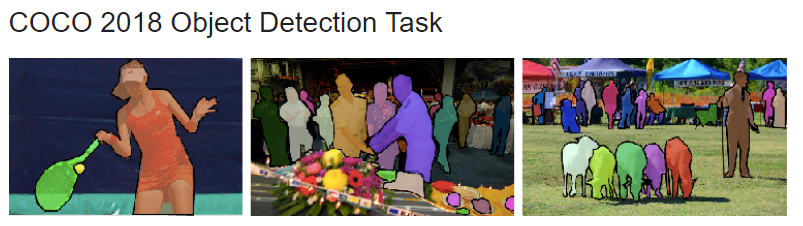

```python
annotation{
"id" : int, 
"image_id" : int, 
"category_id" : int, 
"segmentation" : RLE or [polygon], 
"area" : float, 
"bbox" : [x,y,width,height], 
"iscrowd" : 0 or 1,
}
 
categories[{
"id" : int, 
"name" : str, 
"supercategory" : str,
}]
```

 <span style="color:blue">2) Keypoint Detection</span> 

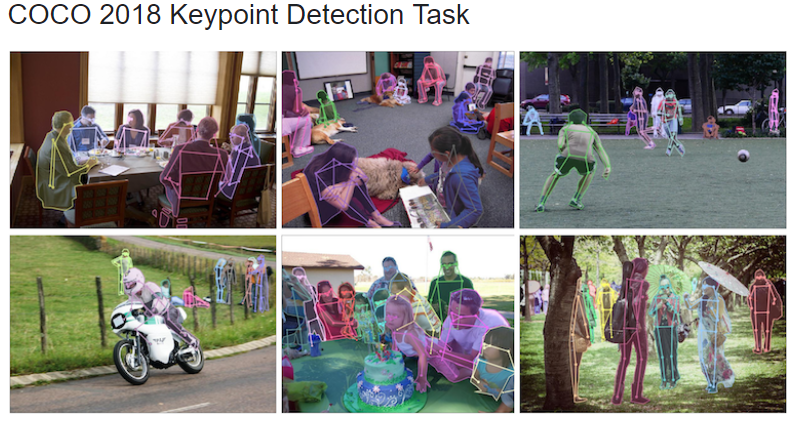

```python
annotation{
"keypoints" : [x1,y1,v1,...], 
"num_keypoints" : int, 
"[cloned]" : ...,
}
 
categories[{
"keypoints" : [str], 
"skeleton" : [edge], 
"[cloned]" : ...,
}]
 
"[cloned]": denotes fields copied from object detection annotations defined above.
```

 <span style="color:blue">3) Panoptic Segmentation</span> 

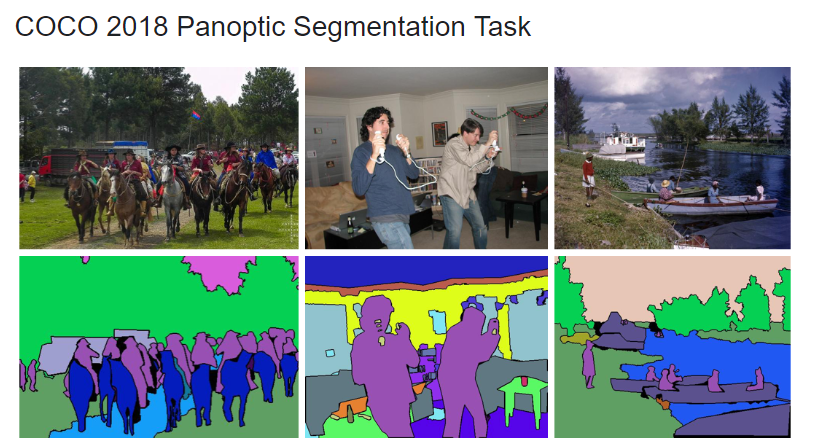

```python
annotation{
"image_id" : int, "file_name" : str, "segments_info" : [segment_info],
}
 
segment_info{
"id" : int,. "category_id" : int, "area" : int, "bbox" : [x,y,width,height], "iscrowd" : 0 or 1,
}
 
categories[{
"id" : int, "name" : str, "supercategory" : str, "isthing" : 0 or 1, "color" : [R,G,B],
}]
```

<span style="color:blue">4) Stuff Segmentation</span> 

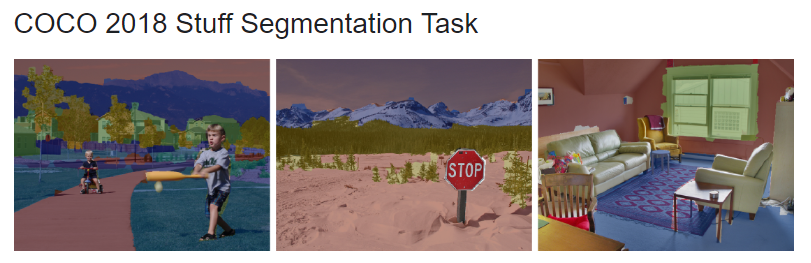

**일부(iscrowd)만 제외하고는 object detection과 양식이 같다.**

<span style="color:blue">5) Image Captioning</span> 

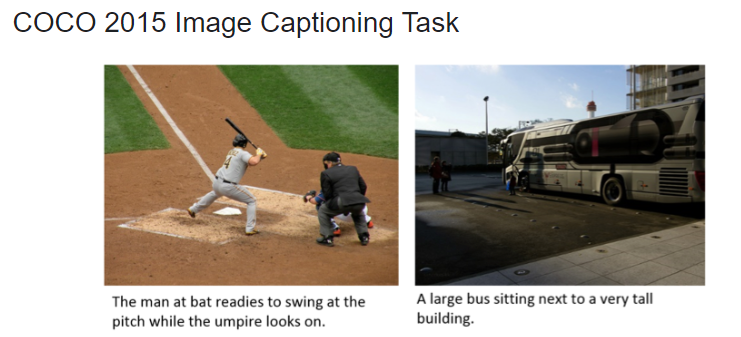

```python
annotation{
"id" : int, "image_id" : int, "caption" : str,
}
```

**3. 활용방법**<br>

coco dataset에 있는 이미지를 이용하여 딥러닝 모델에 사용하기도 하고 , 본인이 탐지하고 싶은 이미지들을 직접 수집하여 coco dataset을 직접 만들어 사용하기도 한다. 


하나의 예시로 coco데이터 셋에서 객체 탐지 라벨을 가져오는 코드를 구현해보자.

```python 
from object_detection.utils import label_map_util

category_index = label_map_util.create_category_index_from_labelmap('models/research/object_detection/data/mscoco_complete_label_map.pbtxt', use_display_name=True)
print(category_index)
detection_class = 0
name = category_index[detection_class + 1]['name']
print(name)
``` 

위처럼 coco dataset의 라벨을 가져와서 모델을 로드하고 학습시켜 객체를 탐지할 수 있다. 

```python
import matplotlib
import matplotlib.pyplot as plt
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
%matplotlib inline

##########모델 로드

category_index = label_map_util.create_category_index_from_labelmap('models/research/object_detection/data/mscoco_complete_label_map.pbtxt', use_display_name=True)

configs = config_util.get_configs_from_pipeline_file('ssd_mobilenet_v1_coco_2018_01_28/pipeline.config')
model = model_builder.build(model_config=configs['model'], is_training=False)

image_tensor = tf.compat.v1.placeholder(tf.float32, shape=[None, None, None, 3])
x_test, shapes = model.preprocess(image_tensor)

dict_output = model.predict(x_test, shapes)

dict_output = model.postprocess(dict_output, shapes)
detection_boxes = dict_output['detection_boxes'] 
detection_classes = dict_output['detection_classes'] 
detection_scores = dict_output['detection_scores'] 
num_detections = dict_output['num_detections'] 

sess = tf.compat.v1.Session()

saver = tf.compat.v1.train.Saver()
saver.restore(sess, 'ssd_mobilenet_v1_coco_2018_01_28/model.ckpt')

##########모델 예측

image = Image.open('car.jpg')
numpy_image = np.array(image)
x_test = np.array([numpy_image])

detection_boxes, detection_classes, detection_scores, num_detections = sess.run([detection_boxes,
                            detection_classes,
                            detection_scores,
                            num_detections], feed_dict={image_tensor: x_test})

detection_classes = detection_classes.astype(dtype=np.int32)
num_detections = num_detections.astype(dtype=np.int32)

viz_utils.visualize_boxes_and_labels_on_image_array(
    numpy_image,
    detection_boxes[0],
    detection_classes[0] + 1,
    detection_scores[0],
    category_index,
    instance_masks=None, 
    use_normalized_coordinates=True, 
    min_score_thresh=0.5)

plt.figure(figsize=(20, 20))
plt.imshow(numpy_image)
plt.show()
```

**4.활용분야** 

coco dataset은 객체 탐지나, segmentation, 영상에서의 사람인식 등 많은 분야에서 활용되고 있는 데이터셋이다. 

자율주행 분야에서 살펴보면, 

  - 카메라 영상을 통해서 `객체를 인식하여 인명사고 문제를 예측`하거나,<br> 
  - `주행가능 영역을 탐지`하고<br>
  - 라이다와 카메라의 `객체 검출 성능 향상`<br>
  
   등 주로 객체 인식을 위한 연구에서 사용되고 있다. 